In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [15]:
DATASET_PATH = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original"

In [17]:
genres = os.listdir(DATASET_PATH)
print("Genres disponibles :", genres)

Genres disponibles : ['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']


In [18]:
import librosa
import numpy as np

def extract_all_features(file_path):
    y, sr = librosa.load(file_path, duration=30)

    # Frame settings
    hop_length = 512
    frame_length = 2048

    # === 1. ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y, hop_length=hop_length)[0])

    # === 2. Spectral Centroid
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)[0])

    # === 3. Spectral Bandwidth
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)[0])

    # === 4. Spectral Rolloff
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)[0])

    # === 5. MFCCs (13)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # === 6. Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    # === 7. Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast_mean = np.mean(contrast, axis=1)

    # === 8. Fréquence fondamentale (F0)
    f0 = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    f0_mean = np.mean(f0)

    # === 9. Tempo
    tempo = librosa.beat.tempo(y=y, sr=sr)[0]

    # === 10. RMS Energy (bonus)
    rms = np.mean(librosa.feature.rms(y=y)[0])

    # === Combine all features ===
    features = [zcr, centroid, bandwidth, rolloff, f0_mean, tempo, rms]
    features += list(mfcc_mean)
    features += list(chroma_mean)
    features += list(contrast_mean)

    return features


In [19]:
# === Extraction
features = []
labels = []
errors = []

import soundfile as sf

# Vérifie si un fichier est lisible
def is_valid_wav(file_path):
    try:
        with sf.SoundFile(file_path) as f:
            return True
    except:
        return False


#genres = sorted(os.listdir(DATASET_PATH))

for genre in genres:
    genre_path = os.path.join(DATASET_PATH, genre)
    for filename in tqdm(os.listdir(genre_path), desc=f"Traitement {genre}"):
        if not filename.endswith(".wav"):
            continue
        file_path = os.path.join(genre_path, filename)

        if not is_valid_wav(file_path):
            print(f"Fichier corrompu : {file_path}")
            errors.append((file_path, "Corrupted file"))
            continue

        try:
            feats = extract_all_features(file_path)
            features.append(feats)
            labels.append(genre)
        except Exception as e:
            print(f"Erreur avec {file_path} : {e}")
            errors.append((file_path, str(e)))

Traitement disco:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_35/346522990.py:40: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y=y, sr=sr)[0]
Traitement jazz:  26%|██▌       | 26/100 [00:19<00:57,  1.28it/s]

Fichier corrompu : /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav


Traitement pop: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


In [22]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


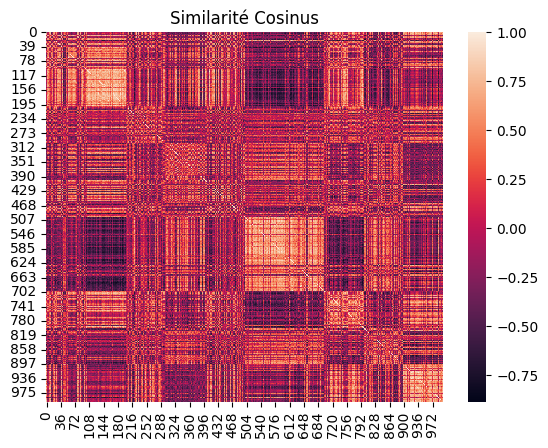

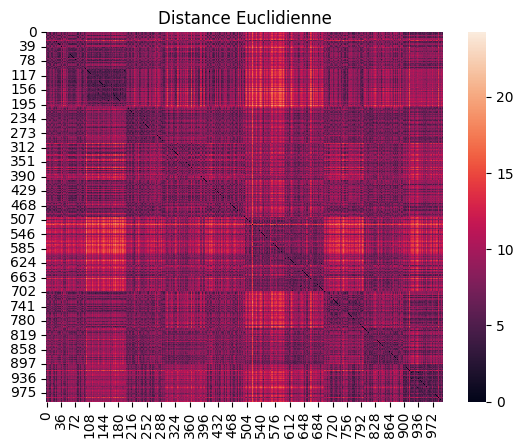

In [23]:
X = np.array(features)

# Optionnel : Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cosine_sim_matrix = cosine_similarity(X_scaled)
euclidean_dist_matrix = euclidean_distances(X_scaled)

# Affichage
sns.heatmap(cosine_sim_matrix)
plt.title("Similarité Cosinus")
plt.show()

sns.heatmap(euclidean_dist_matrix)
plt.title("Distance Euclidienne")
plt.show()


In [24]:
def get_recommendations(index, similarity_matrix, labels, top_n=5):
    sim_scores = list(enumerate(similarity_matrix[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # Exclure l'élément lui-même
    return [(i, labels[i], similarity_matrix[index][i]) for i, _ in sim_scores]


In [25]:
index = 10  # Exemple : audio n°10
recommendations = get_recommendations(index, cosine_sim_matrix, labels)
for idx, genre, score in recommendations:
    print(f"{idx}: Genre={genre}, Similarité={score:.2f}")


78: Genre=disco, Similarité=0.86
99: Genre=disco, Similarité=0.85
226: Genre=reggae, Similarité=0.84
413: Genre=rock, Similarité=0.83
958: Genre=pop, Similarité=0.82


In [26]:
def get_genre_recommendations(target_genre, similarity_matrix, labels, top_n=5):
    indices = [i for i, label in enumerate(labels) if label == target_genre]
    mean_vector = np.mean([similarity_matrix[i] for i in indices], axis=0)

    sim_scores = list(enumerate(mean_vector))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Exclure les morceaux du même genre
    filtered = [(i, labels[i], sim_scores[i][1]) for i, _ in sim_scores if labels[i] != target_genre]
    return filtered[:top_n]


In [27]:
import pandas as pd

# Crée un DataFrame à partir des features
df_features = pd.DataFrame(X_scaled)

# Mesurer la corrélation entre chaque feature et la moyenne des similarités de chaque sample
feature_importance = []
mean_similarities = cosine_sim_matrix.mean(axis=1)

for i in range(df_features.shape[1]):
    corr = np.corrcoef(df_features.iloc[:, i], mean_similarities)[0, 1]
    feature_importance.append((i, corr))

# Tri des features les plus influents
sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Affichage
for idx, score in sorted_features[:10]:
    print(f"Feature {idx} : Corrélation = {score:.2f}")


Feature 35 : Corrélation = -0.86
Feature 34 : Corrélation = -0.85
Feature 36 : Corrélation = -0.83
Feature 33 : Corrélation = -0.76
Feature 37 : Corrélation = -0.75
Feature 7 : Corrélation = 0.73
Feature 26 : Corrélation = 0.71
Feature 23 : Corrélation = 0.69
Feature 14 : Corrélation = 0.69
Feature 21 : Corrélation = 0.68


Les features avec une forte corrélation (en valeur absolue) sont les plus influentes dans la manière dont deux morceaux sont jugés "similaires".

Une corrélation positive signifie que plus la valeur du feature augmente, plus la similarité avec les autres morceaux augmente.

Une corrélation négative signifie que plus la valeur du feature augmente, moins le morceau est jugé similaire aux autres.

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans (choisir k, par exemple k=10 pour GTZAN)
k = 10
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)


Répartition par genre pour chaque cluster

In [30]:
import pandas as pd

df = pd.DataFrame({'cluster': cluster_labels, 'genre': labels})
cluster_distribution = pd.crosstab(df['cluster'], df['genre'])
print(cluster_distribution)


genre    blues  classical  country  disco  hiphop  jazz  metal  pop  reggae  \
cluster                                                                       
0            0          0        0      6      27     0     68    0       0   
1            0          5       26      6       2    20      0   16      11   
2           30          3       27      8       2    25      0    0      19   
3           27          0        8     39      13     1     27    0      10   
4            0          0        0     10      21     0      3   24      11   
5            4          2        0      2      13     2      2    2      36   
6            0         74        0      1       0    14      0    2       0   
7           13          0        7      0       0     1      0    0       1   
8            0          0       16     28      22     9      0   56      11   
9           26         16       16      0       0    27      0    0       1   

genre    rock  
cluster        
0           2  
1  

**Les centres des clusters**

In [31]:
cluster_centers = kmeans.cluster_centers_


**Recommander des morceaux du même cluster qu’un morceau donné**

In [33]:
def recommend_by_cluster(index, cluster_labels, labels, top_n=5):
    cluster = cluster_labels[index]
    indices = [i for i, c in enumerate(cluster_labels) if c == cluster and i != index]
    return [(i, labels[i]) for i in indices[:top_n]]

# Exemple
recommend_by_cluster(10, cluster_labels, labels)


[(0, 'disco'), (6, 'disco'), (11, 'disco'), (14, 'disco'), (18, 'disco')]

**Visualiser les clusters (ACP + t-SNE)**

**PCA**

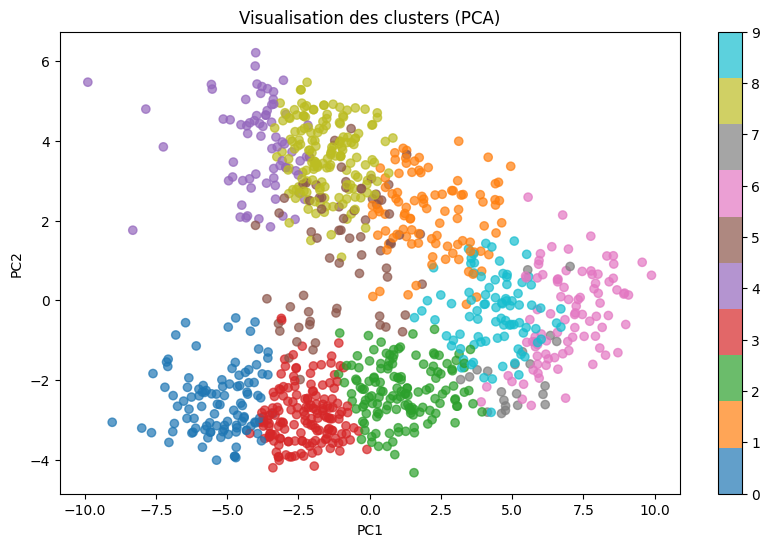

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.title("Visualisation des clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter)
plt.show()


**t-SNE (meilleure séparation visuelle, plus lent)**

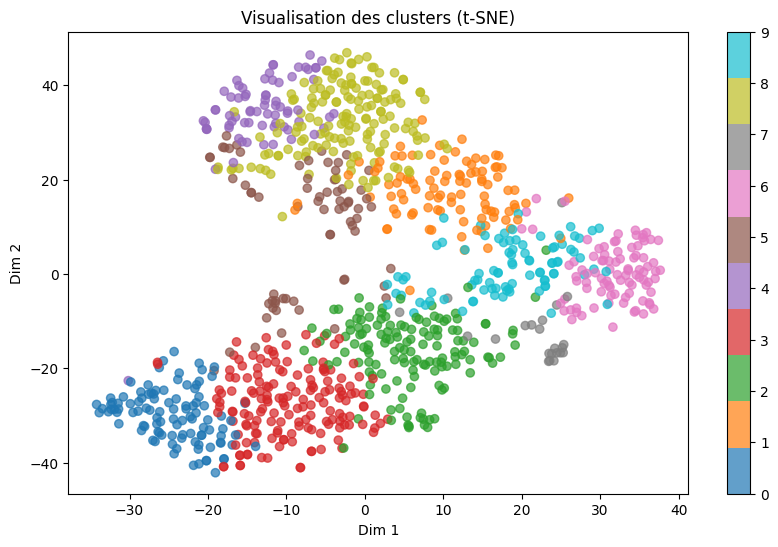

In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.title("Visualisation des clusters (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(scatter)
plt.show()


**Évaluer le bon nombre de clusters**

In [36]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels_k = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels_k)
    scores.append((k, score))

# Afficher les scores
for k, s in scores:
    print(f"k={k}, Silhouette={s:.3f}")


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

k=2, Silhouette=0.226
k=3, Silhouette=0.244
k=4, Silhouette=0.188
k=5, Silhouette=0.151
k=6, Silhouette=0.125
k=7, Silhouette=0.131
k=8, Silhouette=0.105
k=9, Silhouette=0.095
k=10, Silhouette=0.091
k=11, Silhouette=0.096
k=12, Silhouette=0.085
k=13, Silhouette=0.081
k=14, Silhouette=0.080


** Mesures classiques : Accuracy / Précision / Rappel / F1**

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Exemple : pour chaque recommandation, est-ce que le genre est le même ?
def evaluate_recommendations(recommendations, true_label, predicted_labels):
    y_true = [1 if label == true_label else 0 for label in predicted_labels]
    y_pred = [1] * len(predicted_labels)  # on considère qu’on recommande toujours

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return acc, prec, rec, f1


In [39]:
import numpy as np

def dcg(scores):
    return np.sum([(rel / np.log2(idx + 2)) for idx, rel in enumerate(scores)])

def ndcg(recommended_labels, true_label, k=5):
    relevance = [1 if label == true_label else 0 for label in recommended_labels[:k]]
    ideal = sorted(relevance, reverse=True)
    
    dcg_val = dcg(relevance)
    idcg_val = dcg(ideal)

    return dcg_val / idcg_val if idcg_val > 0 else 0.0


In [41]:
def evaluate_all(recommendation_function, labels, k=5):
    ndcg_scores = []
    precisions = []
    recalls = []
    f1s = []

    for idx in range(len(labels)):
        recs = recommendation_function(idx)
        rec_labels = [genre for _, genre in recs]
        acc, prec, rec, f1 = evaluate_recommendations(recs, labels[idx], rec_labels)
        ndcg_score = ndcg(rec_labels, labels[idx], k=k)

        ndcg_scores.append(ndcg_score)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)

    print(f"Moyenne NDCG@{k}: {np.mean(ndcg_scores):.3f}")
    print(f"Précision moyenne : {np.mean(precisions):.3f}")
    print(f"Rappel moyen : {np.mean(recalls):.3f}")
    print(f"F1 Score moyen : {np.mean(f1s):.3f}")


**Diversité : Distance cosinus entre les recommandations**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)  # ou X si déjà défini

# Tester différents nombres de clusters
silhouette_scores = []
k_values = list(range(2, 15))

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(score)

# Visualiser les scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Score de silhouette en fonction du nombre de clusters")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Score de silhouette")
plt.grid(True)
plt.show()
